# 

# Case Study: Analyzing Blood Lead Level and Hypertension

For this chapter, we use the `NHANESsample` dataset seen in
**?@sec-exploratory**. The sample contains lead, blood pressure, BMI,
smoking status, alcohol use, and demographic variables from NHANES
1999-2018. Variable selection and feature engineering were conducted to
replicate the pre-processing conducted by @huang2022association. We
further replicate the regression analysis by @huang2022association in
**?@sec-linear-regression**. Use the help operator `?NHANESsample` to
read the variable descriptions. Note that we ignore survey weights for
this analysis.

In [ ]:
library(HDSinRdata)
library(tidyverse)
library(gt)
library(gtsummary)

data("NHANESsample")

Our analysis focuses on using hypothesis testing to look at the
association between hypertension and blood lead levels by sex. We first
select some demographic and clinical variables that we believe may be
relevant, including age, sex, race, body mass index, and smoking status.
We do a complete case analysis and drop any observations with missing
data.

In [ ]:
NHANESsample <- NHANESsample %>%
  select("AGE", "SEX", "RACE", "SMOKE", "LEAD", "BMI_CAT", 
         "HYP", "ALC") %>%
  na.omit()

We begin with a summary table stratified by hypertension status. As
expected, we see statistically significant differences between the two
groups across all included variables. We also observe higher blood lead
levels and a higher proportion of male participants for those with
hypertension.

In [ ]:
tbl_summary(NHANESsample, by = c("HYP"),
            label = list(SMOKE ~ "SMOKING STATUS",
                         BMI_CAT ~ "BMI",
                         ALC ~ "ALCOHOL USE")) %>%
  add_p() %>%
  add_overall() %>%
  modify_spanning_header(c("stat_1", "stat_2") ~ 
                           "**Hypertension Status**") %>%
  as_gt() %>%
  cols_width(everything() ~ "55pt")

We also plot the distribution of blood lead levels (on a log scale) by
sex and hypertension status. We can visually see that male observations
tend to have higher blood lead levels and that having hypertension is
associated with higher blood lead levels.

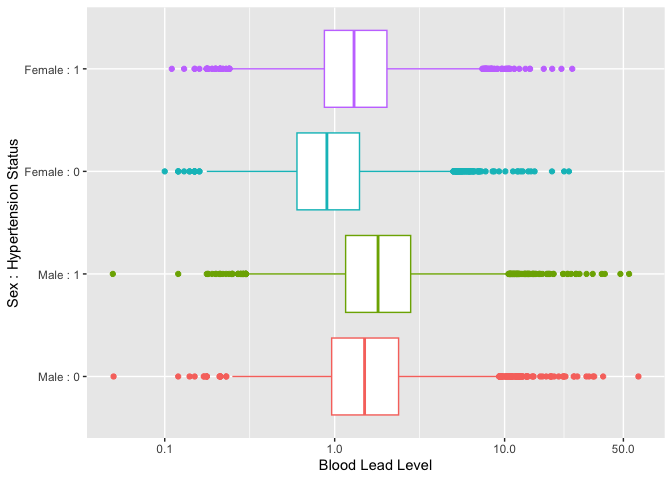

In [ ]:
ggplot(NHANESsample) +
  geom_boxplot(aes(x=LEAD,
                   y = interaction(HYP,SEX),
                   color = interaction(HYP,SEX))) +
  scale_x_continuous(trans = "log", breaks = c(0.1, 1, 10, 50)) +
  scale_y_discrete(labels = c("Male : 0", "Male : 1",
                              "Female : 0", "Female : 1")) +
  guides(color = "none") +
  labs(x="Blood Lead Level",
       y = "Sex : Hypertension Status")

In **?@sec-probability-distributions**, we explored that log blood lead
levels could be approximated by a normal distribution. To test our
hypothesis that there is a difference in mean log blood lead level
between those with and without hypertension, we use a two-sample
unpaired t-test. This shows a statistically significant difference
between the two groups at the 0.05 level.

In [ ]:
t.test(log(LEAD) ~ HYP, data = NHANESsample)


    Welch Two Sample t-test

data:  log(LEAD) by HYP
t = -36.815, df = 28853, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.3141975 -0.2824323
sample estimates:
mean in group 0 mean in group 1 
      0.1607363       0.4590512 

Finally, we repeat this test for a stratified analysis and present the
results in a concise table. For both groups, we find a statistically
significant difference at the 0.05 level.

In [ ]:
# stratify the data
nhanes_male <- NHANESsample[NHANESsample$SEX == "Male",]
nhanes_female <- NHANESsample[NHANESsample$SEX == "Female",]

# t-test for each
test_male <- t.test(log(LEAD) ~ HYP, data = nhanes_male)
test_female <- t.test(log(LEAD) ~ HYP, data = nhanes_female)

# create data frame
res_df <- data.frame(group = c("Male", "Female"),
                     statistic = signif(c(test_male$statistic,
                                          test_female$statistic), 3),
                     p.value = signif(c(test_male$p.value,
                                          test_female$p.value), 3))
res_df

   group statistic   p.value
1   Male     -14.7  1.84e-48
2 Female     -32.3 4.35e-221

In **?@sec-linear-regression**, we use linear regression to further
explore the association between blood lead level and hypertension
adjusting for other potential confounders.